<a href="https://colab.research.google.com/github/mayanksreal/marks-evaluation/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Number Recognition Model (CNN)

## Importing Libraries

In [121]:
!pip install easyocr
!pip install pymupdf
import io
import PIL
import numpy as np
import os
import cv2
import csv

from tensorflow.keras.preprocessing import image #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.datasets import mnist #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input #type:ignore
from tensorflow.keras.callbacks import EarlyStopping #type:ignore
from tensorflow.keras.models import load_model #type:ignore

from google.colab.patches import cv2_imshow #type:ignore
import easyocr
reader = easyocr.Reader(['en'])
import pymupdf

## Importing Dataset

In [122]:
(x_train, y_train) , (x_test, y_test) = mnist.load_data()

## Reshaping

In [123]:
x_train, y_train = x_train.reshape(60000, 28,28,1) , y_train.reshape(60000, 1)
x_test, y_test = x_test.reshape(10000, 28,28,1) , y_test.reshape(10000, 1)

## Normalization

In [124]:
x_train, x_test = x_train/255.0 , x_test/255.0

## Building Model / Train

In [125]:
try:
    model = load_model('model.keras')
except:

    model = Sequential()

    model.add(Input(shape=(28,28,1)))
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))

    model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
    early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(x = x_train , y = y_train, validation_split = 0.2, epochs = 30, batch_size = 1000, callbacks = [early])
    model.save('model.keras')

In [126]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5554 - loss: 1.3650


[1.3868762254714966, 0.5335000157356262]

# OCR/ CNN function

## CNN

In [127]:
def hand_prediction(img_obj):
    image = img_obj
    def remove_borders(image, border_size=5):
        # Crop out the borders by a fixed size
        return image[border_size:-border_size, border_size:-border_size]
    # Remove borders from the entire image
    image = remove_borders(image, border_size=5)

    image = cv2.cvtColor(image, cv2. COLOR_BGR2GRAY)

    # Apply binary thresholding to the image
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by their x position
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    digits = []

    global num
    global probability
    global n
    num = 0

    for ctr in contours:
        num = num*10
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(ctr)

        # Add padding to the bounding box
        padding = 5  # Adjust padding as needed
        x = max(x - padding, 0)
        y = max(y - padding, 0)
        w = min(w + 2 * padding, image.shape[1] - x)
        h = min(h + 2 * padding, image.shape[0] - y)

        # Extract the digit using the bounding box
        digit = thresh[y:y+h, x:x+w]
        # Resizing to fit model input
        resized_digit = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)
        # Normalization
        digit = resized_digit / 255.0
        r = model.predict(digit.reshape(1,28,28,1))

        if np.max(r) < 0.95:

            cv2_imshow(np.reshape((digit*255), (28,28,1)))
            print(f"Predicted:{np.argmax(r)} ({round(np.max(r)*100,2)})")
            print("Actual:")
            n = input()
            if n == '':
                pass
                num = int(num/10)
            else:
              n = int(n)
              digit = digit.reshape(1,28,28,1)
              model.fit(digit, np.array([[n]]))
              model.save('model.keras')
              num = num + n
        else:
            num = num + np.argmax(r)
            print(np.max(r))


    return [num]

## OCR

In [128]:
def ocr_prediction(img_obj):
    try:
        results = reader.readtext(img_obj)
        result_set = set()
        if len(results) > 1:
            for x in results[0][1]:
                result_set.add(x)
            for x in results[1][1]:
                result_set.add(x)

        if results:
            return results
        else:
            return 'ERR'
    except Exception as e:
        return 'ERR'

## ALL PAGES
Now for all pages, we cascadingly call all functions, in a for loop


In [129]:
def read_pdf(pdf_path):
    pdf_document = pymupdf.open(pdf_path)
    global rows_written
    rows_written = 0

    if not os.path.exists('outputs'):
        os.makedirs('outputs')


    #Clearing any past file
    with open('outputs/output.csv', mode='w') as csv_file:
        csv_writer = csv.writer(csv_file)

    with open('outputs/attention.txt', mode='w') as txt_file:
        txt_write = txt_file.write('')

    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        # To image (using matrix transformation)
        zoom = 2  # Adjust zoom level as needed
        mat = pymupdf.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat, alpha=False)

        # pixmap to PIL Image
        img_bytes = pix.tobytes("ppm")
        image = PIL.Image.open(io.BytesIO(img_bytes))

        image = np.array(image)

        #return image

        #instead lets read all pages

        table = get_table(image, page_number)

In [130]:
def get_table(image, page_number):
    ## Filters
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)


    ## Contour detection
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
    table_contour = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        if len(approx) == 4:
            table_contour = approx
            break

    if table_contour is not None:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(table_contour)

        # Crop the table region from the original image
        table_image = image[y:y+h, x:x+w]
        num_rows = 0

        #return table_image

        extract_cells_to_csv(table_image, page_number)

    else:
        print("error")

In [131]:
def extract_cells_to_csv(image, page_number, csv_filename='outputs/output.csv'):

    # Determining n rows using table height
    # height = 181 + 59*rows
    height = len(image)
    num_rows = round((height - 181) / 59)
    global rows_written

    # Parameters (adjust these values as needed)
    title_offset = 106 + (num_rows * 2)  # Offset title
    header_row_height = 75  # Height header
    row_height = 57  # Height each row

    # Column width
    col_names = ["SNo.","ID","NAME","DOB","INTERVIEW MARKS"]
    column_widths = [67, 73, 392 + (num_rows * 2), 175, 380]

    # Function get column boundaries
    def get_column_boundaries(column_widths):
        boundaries = [0]
        for width in column_widths:
            boundaries.append(boundaries[-1] + width)
        return boundaries

    column_boundaries = get_column_boundaries(column_widths)

    # Opening CSV file
    with open(csv_filename, mode='a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        if page_number == 0:
          # Extract header row
          header_row = image[title_offset:title_offset + header_row_height, :]
          header_cells = []

          # header row
          for col in range(0,5):
              cell = header_row[:, column_boundaries[col]:column_boundaries[col + 1]]
              cell_image = np.array(cell)
              header_cells.append(ocr_prediction(cell_image)[0][1])

          # writing header row
          csv_writer.writerow(header_cells)

        # next rows
        for row in range(1, num_rows + 1):
            row_start = title_offset + header_row_height + (row - 1) * row_height
            row_end = row_start + row_height
            table_row = image[row_start:row_end, :]
            row_cells = []

            # Process row
            row_cells.append(f'{row + rows_written}')
            for col in range(1,5):
                cell = table_row[:, column_boundaries[col]:column_boundaries[col + 1]]
                cell_image = np.array(cell)
                if col < 4:

                   if len(ocr_prediction(cell_image)) > 1:
                       cv2_imshow(cell_image)
                       print(f"PREDICTION:{ocr_prediction(cell_image)[0][1]}")
                       print("ACTUAL:")
                       n = str(input())
                       row_cells.append(n)
                   else:
                      row_cells.append(ocr_prediction(cell_image)[0][1])

                if col == 4:
                    r = hand_prediction(cell_image)
                    row_cells.append(r[0])

            # Write the row to the CSV
            csv_writer.writerow(row_cells)

    print(f"Written {num_rows} row(s) to '{csv_filename}'.")
    rows_written += num_rows

ADDING PROBABILITY BASED WARNING FOR CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.99447197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.9990007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.99398804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.99838626
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Predicted:3 (37.87)
Actual:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.9661077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9950191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.9822971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.99466085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Predicted:5 (73.23)
Actual:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.99782014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.99425095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9899162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.9990335


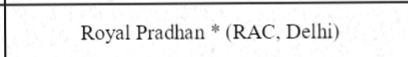

PREDICTION:Royal Pradhan
ACTUAL:
Royal Pradhan * (RAC, Delhi)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.97927135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.99348193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.965488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Predicted:5 (63.74)
Actual:

Written 8 row(s) to 'outputs/output.csv'.


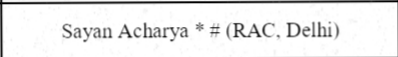

PREDICTION:Sayan Acharya
ACTUAL:
Sayan Acharya *# (RAC,Delhi)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.99266326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.9870002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Predicted:7 (94.68)
Actual:
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.9888031
Written 3 row(s) to 'outputs/output.csv'.


In [133]:
read_pdf("scanned.pdf")